In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd

import mpmp.config as cfg
from mpmp.data_models.tcga_data_model import TCGADataModel
import mpmp.utilities.data_utilities as du

In [2]:
# load some data we need, this takes a bit
tcga_data = TCGADataModel(seed=cfg.default_seed, verbose=False)
pancancer_data = du.load_pancancer_data()

In [3]:
def gene_sample_count(gene, data_model, classification='neither'):
    try:
        tcga_data.process_data_for_gene(gene,
                                        classification,
                                        None)
        sample_count = tcga_data.X_df.shape[0]
        cancer_types = (tcga_data.sample_info_df
          .loc[tcga_data.X_df.index, 'cancer_type']
          .unique()
        )
    except KeyError:
        sample_count = np.nan
        cancer_types = []
        
    return (gene, sample_count, cancer_types)

In [4]:
# cache partial results and load them
output_file = Path('./gene_sample_count_no_copy.tsv')
if output_file.is_file():
    output_df = pd.read_csv(output_file, sep='\t', index_col=0)
else:
    output_df = pd.DataFrame()
    
print(output_df.shape)
output_df.head()

(0, 0)


""


In [5]:
print(gene_sample_count('TP53', tcga_data, classification='TSG'))

('TP53', 3804, array(['LUAD', 'OV', 'LUSC', 'PRAD', 'BLCA', 'ESCA', 'PAAD', 'SARC',
       'BRCA', 'COAD', 'STAD', 'SKCM', 'UCEC', 'CESC', 'READ', 'HNSC',
       'LIHC', 'LGG', 'KICH', 'UCS'], dtype=object))


In [6]:
mutation_df = pancancer_data[1]
mutation_df.iloc[:5, :5]

,5S_rRNA,A1BG,A1CF,A2M,A2ML1
SAMPLE_BARCODE,,,,,
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0
TCGA-02-2483-01,0,0,0,0,0
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


In [7]:
save_every = 100

gene_list = mutation_df.columns
for gene_ix, gene in enumerate(gene_list):
    
    # if gene has already been processed, skip it
    if gene in output_df.index:
        continue
        
    # load sample count for gene
    gene_name, sample_count, cancer_types = gene_sample_count(
        gene,
        tcga_data,
        classification='neither')
    
    # add to output dataframe
    output_df = pd.concat((
        output_df,
        pd.DataFrame([[sample_count, cancer_types]],
                     index=[gene_name],
                     columns=['sample_count', 'cancer_types'])
    ))
    
    # save results every save_every genes, and at the end of all genes
    # this allows us to restart if this runs for a while and gets interrupted
    progress_ix = gene_ix + 1
    if ((progress_ix % save_every == 0) or (progress_ix == len(gene_list))) and (gene_ix != 0):
        print('processed: {} / {}'.format(gene_ix+1, len(gene_list)),
              file=sys.stderr)
        output_df.to_csv(output_file, sep='\t')

processed: 100 / 20938
processed: 200 / 20938
processed: 300 / 20938
processed: 400 / 20938
processed: 500 / 20938
processed: 600 / 20938
processed: 700 / 20938
processed: 800 / 20938
processed: 900 / 20938
processed: 1000 / 20938
processed: 1100 / 20938
processed: 1200 / 20938
processed: 1300 / 20938
processed: 1400 / 20938
processed: 1500 / 20938
processed: 1600 / 20938
processed: 1700 / 20938
processed: 1800 / 20938
processed: 1900 / 20938
processed: 2000 / 20938
processed: 2100 / 20938
processed: 2200 / 20938
processed: 2300 / 20938
processed: 2400 / 20938
processed: 2500 / 20938
processed: 2600 / 20938
processed: 2700 / 20938
processed: 2800 / 20938
processed: 2900 / 20938
processed: 3000 / 20938
processed: 3100 / 20938
processed: 3200 / 20938
processed: 3300 / 20938
processed: 3400 / 20938
processed: 3500 / 20938
processed: 3600 / 20938
processed: 3700 / 20938
processed: 3800 / 20938
processed: 3900 / 20938
processed: 4000 / 20938
processed: 4100 / 20938
processed: 4200 / 20938
p

In [8]:
print(output_df.shape)
output_df.head()

In [10]:
valid_genes = (output_df.sample_count > 0).sum()
print('Valid genes:', valid_genes, '/', output_df.shape[0])

Valid genes: 1348 / 20938


In [12]:
output_df['num_cancer_types'] = output_df.cancer_types.str.len()
output_df.head()

,sample_count,cancer_types,num_cancer_types
5S_rRNA,0,[],0
A1BG,0,[],0
A1CF,149,[SKCM],1
A2M,0,[],0
A2ML1,149,[SKCM],1


Text(0.5, 1.0, 'Number of valid cancer types, per gene')

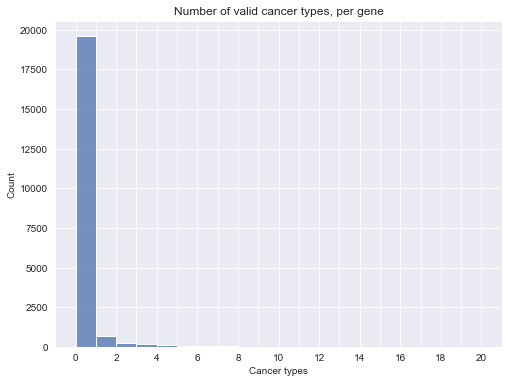

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set({'figure.figsize': (8, 6)})

sns.histplot(output_df.num_cancer_types, binwidth=1)
plt.xticks(range(0, output_df.num_cancer_types.max()+1))
plt.setp(plt.gca().get_xticklabels()[1::2], visible=False)
plt.xlabel('Cancer types')
plt.title('Number of valid cancer types, per gene')

Text(0.5, 1.0, 'Number of valid cancer types, per gene')

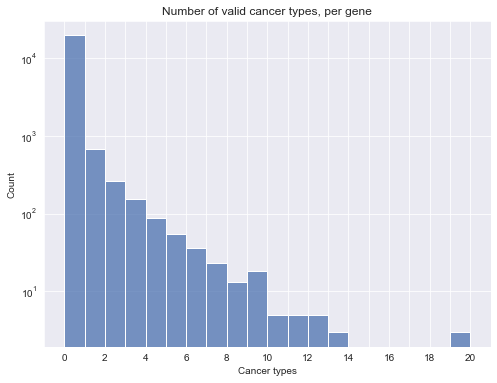

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set({'figure.figsize': (8, 6)})

sns.histplot(output_df.num_cancer_types, binwidth=1)
plt.xticks(range(0, output_df.num_cancer_types.max()+1))
plt.setp(plt.gca().get_xticklabels()[1::2], visible=False)
plt.xlabel('Cancer types')
plt.yscale('log')
plt.title('Number of valid cancer types, per gene')